<a href="https://colab.research.google.com/github/bakudbilla/Hamoye_internship/blob/main/notebookf5264c488b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'planet-understanding-the-amazon-from-space:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F6322%2F868312%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T171634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D16cd2760c3509a7f7fa6f4919b152177986c4a79b03e1ce455846a96ad2967107d6f48845ab42e2945f045a78676b851b23d93f325f776cb61826a7137cb38f1bf2a2e805f5d547e16000d1802ebdd49be7c36908b4b235d8dd61165a0beafb43984994391cc11fa1a507dd9fcf6d3c4baedcceba1b40ceaa2cbd3b772a80c0d299c5ada0e1ef24a28cda72fcac0f718b27801c337f058af3b40768a066665bf326c198adf9c2e0874d8faf45522fe25a7435bc30bcdd280efa5ef056ecef4c3a4afe3bf9ffb471564a365d75c4dd72c58e05ecac79773198dc8acbdf7d94aca85f857cd3a581cb065f026cf4d9a31cc39a09390dfee878d95e45c6a52967037'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3080605 bytes downloaded
Downloaded and uncompressed: planet-understanding-the-amazon-from-space
Data source import complete.


In [4]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-train-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-test-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv/test_v2_file_mapping.csv
/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv
/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv


In [5]:
# Importing the necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import gc
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
#from tqdm import tqdm
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [13]:
#Loading the image datasets
train_path = '/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv'
test_path = '/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv'
train_images = '/content/train-jpg (2).zip'
test_images = '/content/test-jpg.zip'

BadZipFile: File is not a zip file

In [11]:
# Loading the train and test datasets
train_df = pd.read_csv(train_path)
print(train_df.shape)
train_df.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
test_df = pd.read_csv(test_path)
print(test_df.shape)
test_df.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


FileNotFoundError: [Errno 2] No such file or directory: '/content/train-jpg (2).ziptrain_0.jpg'

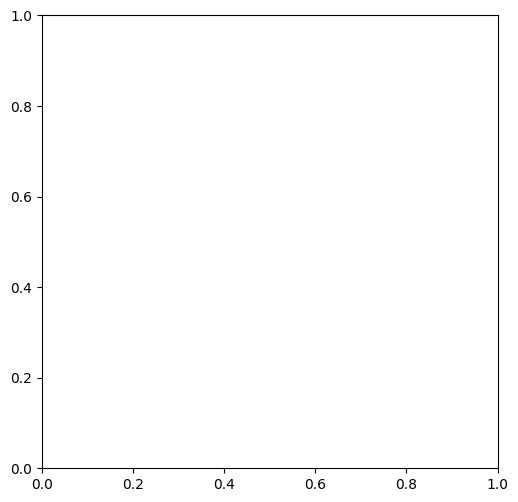

In [12]:
# Let's view some images
plt.figure(figsize=(20,20))
# define location of dataset
folder = train_images
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'train_' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()